<a href="https://colab.research.google.com/github/entc-17-fyp-20/WPF_Data_Visualization/blob/main/SARIMA_Wind_Speed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing python packages**

In [ ]:
pip install pmdarima

In [30]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import matplotlib
import pmdarima as pm

# **Data Preprocessing**

In [31]:
df = pd.read_csv('https://raw.githubusercontent.com/entc-17-fyp-20/Datasets/main/V13%20June%2010%20sec%20data.csv')
df=df[['Date & Time','Wind Speed m/s']]
df['Date & Time'] = pd.to_datetime(df['Date & Time'], format="%d/%m/%Y %H:%M:%S")
df["Wind Speed m/s"] = pd.to_numeric(df["Wind Speed m/s"])
df.set_index('Date & Time',inplace=True)
df=df.head(10000)
df.head()

,Wind Speed m/s
Date & Time,
2021-06-02 00:00:00,8.4
2021-06-02 00:00:10,8.3
2021-06-02 00:00:20,8.2
2021-06-02 00:00:30,8.4
2021-06-02 00:00:40,9.2


**Resampling data**

In [32]:
df_resampled = df.resample('10min').mean()
df_resampled.head()

,Wind Speed m/s
Date & Time,
2021-06-02 00:00:00,8.900000
2021-06-02 00:10:00,8.708333
2021-06-02 00:20:00,8.853333
2021-06-02 00:30:00,8.731667
2021-06-02 00:40:00,9.021667


In [33]:
df_resampled.describe()

,Wind Speed m/s
count,167.000000
mean,8.078822
std,0.767081
min,6.155000
25%,7.683333
50%,8.203333
75%,8.600000
max,9.910000


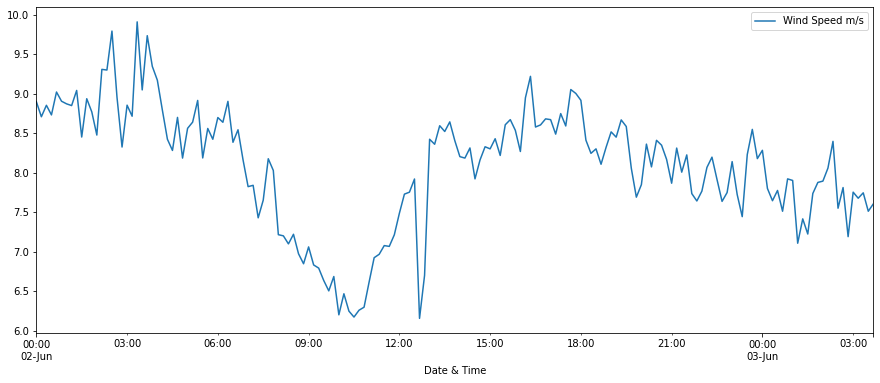

In [34]:
df_resampled.plot(figsize = (15, 6))
plt.show()

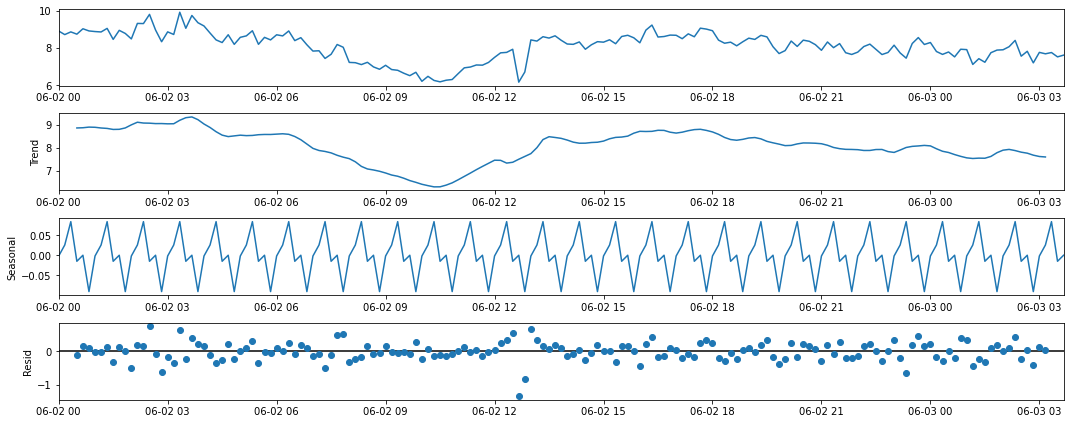

In [35]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 6
decomposition = sm.tsa.seasonal_decompose(df_resampled, model='additive',period=6)
fig = decomposition.plot()
plt.show()

*sesonal_lags_6*

# **Check Data Stationarity**

In [36]:
from statsmodels.tsa.stattools import adfuller
def check_stationarity(timeseries):    
    result = adfuller(timeseries,autolag='AIC')
    dfoutput = pd.Series(result[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    print('The test statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [37]:
check_stationarity(df_resampled["Wind Speed m/s"])

The test statistic: -2.052249
p-value: 0.264143
Critical Values:
	1%: -3.471
	5%: -2.879
	10%: -2.576


not-stationary

In [38]:
df_diff=df_resampled.diff(periods=1)
df_diff=df_diff[1:]
df_diff.head()

,Wind Speed m/s
Date & Time,
2021-06-02 00:10:00,-0.191667
2021-06-02 00:20:00,0.145000
2021-06-02 00:30:00,-0.121667
2021-06-02 00:40:00,0.290000
2021-06-02 00:50:00,-0.116667


In [39]:
check_stationarity(df_diff["Wind Speed m/s"])

The test statistic: -8.964523
p-value: 0.000000
Critical Values:
	1%: -3.471
	5%: -2.880
	10%: -2.576


now the series is trend stationary(d=1)

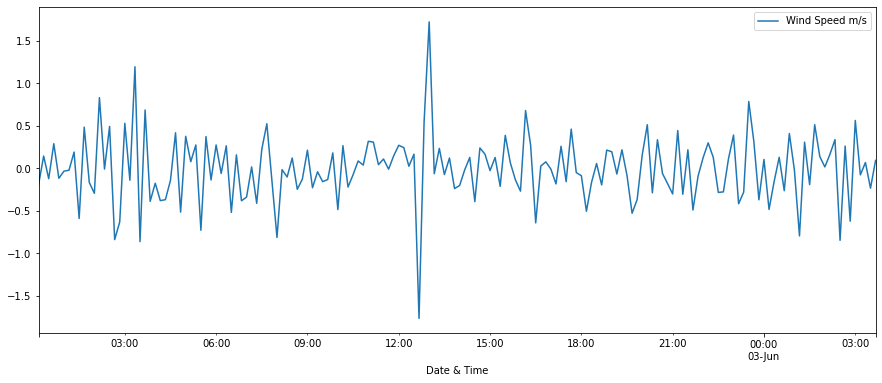

In [40]:
df_diff.plot(figsize = (15, 6))
plt.show()

In [41]:
df_sdiff=df_diff.diff(periods=6)

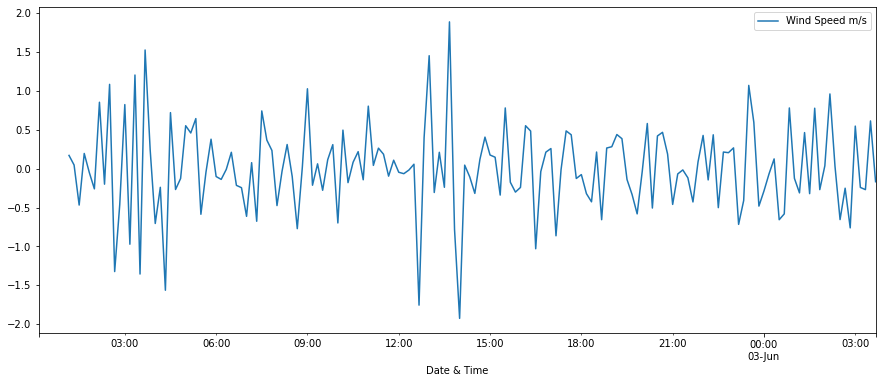

In [42]:
df_sdiff.plot(figsize = (15, 6))
plt.show()

In [ ]:
from pmdarima import auto_arima
stepwise_fit = auto_arima(df_resampled["Wind Speed m/s"], trace=True,suppress_warnings=True)

In [66]:
train=df_resampled[0:140]
test=df_resampled[140:]

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


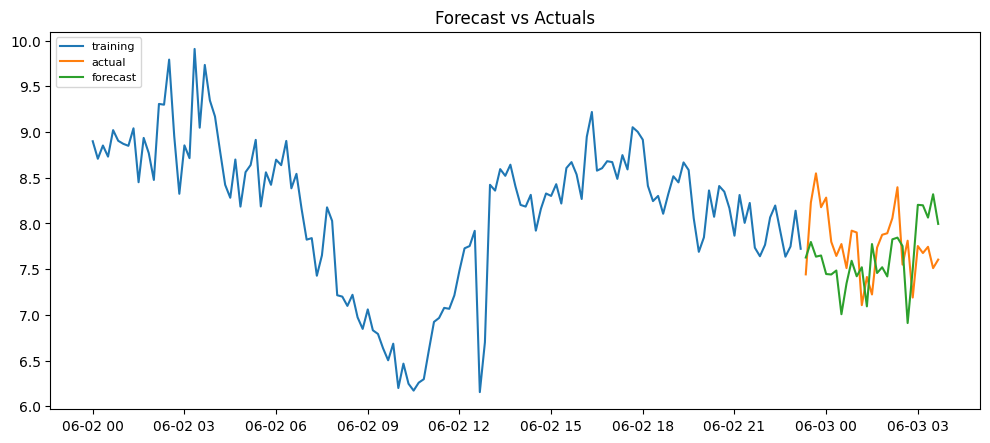

In [98]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
# Create a SARIMAX model
model = SARIMAX(train, order=(2, 1, 2), seasonal_order=(1, 1, 12, 12))
# Fit the model
results = model.fit()
# Print the results summary
#results.summary()
fc= results.forecast(27)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()